<a href="https://colab.research.google.com/github/varinen/introtf/blob/master/Week_3_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Improving Computer Vision Accuracy With Convolutions

Previously, we've built a deep neural network (DNN) with three layers: input, hidden, and output. This is how the code looked like:

In [0]:
import tensorflow as tf

In [3]:
mnist = tf.keras.datasets.fashion_mnist
(training_images, training_labels), (test_images, test_labels) \
= mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [8]:
# normalize
training_images = training_images / 255.0
test_images = test_images / 255.0

model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
             metrics=['accuracy'])
model.fit(training_images, training_labels, epochs=5)

test_loss = model.evaluate(test_images, test_labels)

Epoch 1/5
60000/60000 [==============================] - 7s 122us/sample - loss: 1.0701 - acc: 0.6672
Epoch 2/5
60000/60000 [==============================] - 6s 107us/sample - loss: 0.6353 - acc: 0.7706
Epoch 3/5
60000/60000 [==============================] - 6s 107us/sample - loss: 0.5612 - acc: 0.7981
Epoch 4/5
60000/60000 [==============================] - 6s 107us/sample - loss: 0.5189 - acc: 0.8167
Epoch 5/5
10000/10000 [==============================] - 0s 46us/sample - loss: 0.5047 - acc: 0.8196


Let's try it again:

In [7]:
(training_images, training_labels), (test_images, test_labels) = mnist.load_data()
training_images=training_images / 255.0
test_images=test_images / 255.0
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation=tf.nn.relu),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(training_images, training_labels, epochs=5)

test_loss = model.evaluate(test_images, test_labels)

Epoch 1/5
60000/60000 [==============================] - 7s 109us/sample - loss: 0.5001 - acc: 0.8243
Epoch 2/5
60000/60000 [==============================] - 6s 106us/sample - loss: 0.3718 - acc: 0.8649
Epoch 3/5
60000/60000 [==============================] - 6s 106us/sample - loss: 0.3351 - acc: 0.8769
Epoch 4/5
60000/60000 [==============================] - 6s 106us/sample - loss: 0.3130 - acc: 0.8853
Epoch 5/5
10000/10000 [==============================] - 0s 44us/sample - loss: 0.3554 - acc: 0.8718


## Convolutions

The accuracy yielded by the original method is about 81-87%. It can be improved by emploing filter processing called Convolutions. An example of filter (kernel) processing is explained here: https://en.wikipedia.org/wiki/Kernel_(image_processing).

In out case, Convolutuons will be a 3 by 3 pixel square that passes over the image. It will improve edge detection by apllying a matrix of multipliers. For edge detection such matrix will have 8 for the central pixels and -1 for all its neighbours. That means, that for each pixel in the image, we will multiply its value by 8 and then subtract the values of its neighbours. Once this is done, the new image will have its edges enhanced.

Now, the DNN will be able to operate on an enhanced edge feature, which is supposed to improve performance.

See the modified code that includes 4 new layers. First, a reshape is needed. The convolution layer expects a single 4D object instead of a list of 3D objects.

We apply the first convolution that uses a 3 x 3 matrix. In the summary view you can see that the output data shape is now 26 by 26 instead of 28 by 28 pixel. The reason is that the 3 x 3 matrixs can be applied to all pixels except the ones in the outermost rows and columns - these do not have the complete set of neighbours. Because of this they are discarded.

The pooling layer performs the following operation: it takes a 2 by 2 matrix across all the image pixels. In each matrix it look at the pixel with the highest value and keeps it, the other 3 pixels are discarded. Thus, the image is halved in width and height. In the output we have a picture twice as small as the input. 

If the dimensions of the original image are odd (e.g. 11 by 11), the pooling will round down and produce an image 5 by 5 pixel.

In [24]:
import tensorflow as tf
print(tf.__version__)
mnist = tf.keras.datasets.fashion_mnist
(training_images, training_labels), (test_images, test_labels) = mnist.load_data()
training_images=training_images.reshape(60000, 28, 28, 1)
training_images=training_images / 255.0
test_images = test_images.reshape(10000, 28, 28, 1)
test_images=test_images/255.0
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(28, 28, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()
model.fit(training_images, training_labels, epochs=5)
test_loss = model.evaluate(test_images, test_labels)


1.13.1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               204928    
_________________________________________________________________
dense_15 (Dense)             (None, 10)                1290      
Tot

The training of this model takes much longer. But the accuracy is now almost 91%

Let's see how the images look like during the convolution and pooling phases.

# Visualization the Convolutions and Pooling.

Let's see, what are the first 100 labels of the test label set:


In [26]:
print(test_labels[:100])

[9 2 1 1 6 1 4 6 5 7 4 5 7 3 4 1 2 4 8 0 2 5 7 9 1 4 6 0 9 3 8 8 3 3 8 0 7
 5 7 9 6 1 3 7 6 7 2 1 2 2 4 4 5 8 2 2 8 4 8 0 7 7 8 5 1 1 2 3 9 8 7 0 2 6
 2 3 1 2 8 4 1 8 5 9 5 0 3 2 0 6 5 3 6 7 1 8 0 1 4 2]


We can see, labels at indices 0, 23, and 28 are 9, that is "shoe". Let's see if applying convolutions enhances common features of a shoe image:


9
1
1


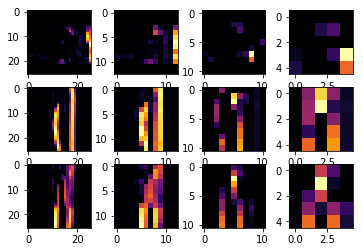

In [34]:
import matplotlib.pyplot as plt
f, axarr = plt.subplots(3,4)
FIRST_IMAGE=0
SECOND_IMAGE=2
THIRD_IMAGE=3
CONVOLUTION_NUMBER=1

print(test_labels[FIRST_IMAGE])
print(test_labels[SECOND_IMAGE])
print(test_labels[THIRD_IMAGE])

from tensorflow.keras import models

layer_outputs = [layer.output for layer in model.layers]
activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)

for x in range(0, 4):
  f1 = activation_model.predict(test_images[FIRST_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[0,x].imshow(f1[0, :, :, CONVOLUTION_NUMBER], cmap='inferno')
  axarr[0,x].grid(False)
  
  f2 = activation_model.predict(test_images[SECOND_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[1,x].imshow(f2[0, :, :, CONVOLUTION_NUMBER], cmap='inferno')
  axarr[1,x].grid(False)
  
  f3 = activation_model.predict(test_images[THIRD_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[2,x].imshow(f3[0, :, :, CONVOLUTION_NUMBER], cmap='inferno')
  axarr[2,x].grid(False)
  
  
  

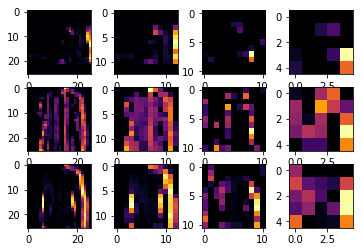

In [29]:
import matplotlib.pyplot as plt
f, axarr = plt.subplots(3,4)
FIRST_IMAGE=0
SECOND_IMAGE=7
THIRD_IMAGE=26
CONVOLUTION_NUMBER = 1
from tensorflow.keras import models
layer_outputs = [layer.output for layer in model.layers]
activation_model = tf.keras.models.Model(inputs = model.input, outputs = layer_outputs)
for x in range(0,4):
  f1 = activation_model.predict(test_images[FIRST_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[0,x].imshow(f1[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
  axarr[0,x].grid(False)
  f2 = activation_model.predict(test_images[SECOND_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[1,x].imshow(f2[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
  axarr[1,x].grid(False)
  f3 = activation_model.predict(test_images[THIRD_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[2,x].imshow(f3[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
  axarr[2,x].grid(False)

In [35]:
import tensorflow as tf
print(tf.__version__)
mnist = tf.keras.datasets.mnist
(training_images, training_labels), (test_images, test_labels) = mnist.load_data()
training_images=training_images.reshape(60000, 28, 28, 1)
training_images=training_images / 255.0
test_images = test_images.reshape(10000, 28, 28, 1)
test_images=test_images/255.0
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(training_images, training_labels, epochs=10)
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(test_acc)

1.13.1
11493376/11490434 [==============================] - 0s 0us/step
Epoch 1/10
60000/60000 [==============================] - 53s 888us/sample - loss: 0.1501 - acc: 0.9550
Epoch 2/10
60000/60000 [==============================] - 53s 887us/sample - loss: 0.0528 - acc: 0.9837
Epoch 3/10
60000/60000 [==============================] - 55s 910us/sample - loss: 0.0335 - acc: 0.9897
Epoch 4/10
60000/60000 [==============================] - 55s 919us/sample - loss: 0.0232 - acc: 0.9926
Epoch 5/10
60000/60000 [==============================] - 54s 899us/sample - loss: 0.0163 - acc: 0.9948
Epoch 6/10
60000/60000 [==============================] - 53s 884us/sample - loss: 0.0106 - acc: 0.9966
Epoch 7/10
60000/60000 [==============================] - 53s 884us/sample - loss: 0.0086 - acc: 0.9972
Epoch 8/10
60000/60000 [==============================] - 53s 888us/sample - loss: 0.0071 - acc: 0.9979
Epoch 9/10
60000/60000 [==============================] - 54s 892us/sample - loss: 0.0052 - acc: